In [30]:
#| default_exp widget_helpers

In [31]:
#| export
from __future__ import annotations

# Helpers

> ...

# Prologue

In [32]:
#| export

import asyncio
import shutil
import time
from functools import cached_property
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Protocol
from typing import Self

import fastcore.all as FC
import ipywidgets as W
import nbdev.config
from fastcore.xml import FT
from fastcore.xml import NotStr
from fasthtml.basics import ft_html
from jupyter_ui_poll import ui_events
from olio.basic import Empty
from olio.basic import empty

In [33]:
#| export

from bridget.helpers import _get_globals
from bridget.helpers import run_command

In [34]:
import inspect
import itertools
import tempfile
from pathlib import Path

import anywidget
from anyio import from_thread
from bridget.display_helpers import displaydh
from fastcore.test import *
from IPython.display import DisplayHandle
from ipywidgets.widgets.widget import CallbackDispatcher
from jupyter_ui_poll import run_ui_poll_loop
from jupyter_ui_poll import with_ui_events
from olio.callback import Callback
from olio.callback import HasCallbacks
from olio.common import setup_console
from olio.test import test_raises


In [35]:
from bridget.helpers import arun_command
from bridget.helpers import bundle_path
from bridget.helpers import kounter

----

In [36]:
console, cprint = setup_console(140)

In [37]:
#| exporti

_n = '\n'

----

# Widget Helpers

# cleanupwidgets
> Helper to properly cleanup ipywidget instances by closing their comms.

When working with ipywidgets in notebooks, each widget creates a comm channel with the kernel. During development, it's better to to close the widgets, to avoid memory leaks and kernel issues.


In [38]:
#| export

def cleanupwidgets(*ws, mod: str|None=None, clear=True):
    from IPython.display import clear_output
    glb = _get_globals(mod or __name__)
    for w in ws:
        _w = glb.get(w) if isinstance(w, str) else w
        if _w:
            try: _w.close()  # type: ignore
            except: pass
    if clear: clear_output(wait=False)

In [39]:
_b = W.Button()
test_eq(_b.comm is not None, True)
cleanupwidgets('_b')
test_is(_b.comm, None)

# read_vfile

Hacking around to get anywidget `vfile:` working in Script and Style. 
Unfortunately, it's not a public API. If useful, we could write a similar util for Bridget.

NOTE: %load_ext anywidget must have been previously run for this to work

In [40]:
#| export

def read_vfile(cts:str)->str|None:
    # %load_ext anywidget should have been previously run for this to work
    import anywidget
    from anywidget._file_contents import _VIRTUAL_FILES
    if isinstance(cts, str) and cts.startswith('vfile:'):
        if fn := _VIRTUAL_FILES.get(cts, None):
            return fn.contents

# vfile: Components

> **FastHTML** xtend `Script` and `Style` with `vfile:` support.

In [41]:
#| export

@FC.delegates(ft_html, keep=True)  # type: ignore
def ScriptV(code:str="", **kwargs)-> FT:
    "A Script w/ code or `vfile:` contents that doesn't escape its code"
    return ft_html('script', (_n, NotStr(FC.ifnone(read_vfile(code), code))), **kwargs)

@FC.delegates(ft_html, keep=True)  # type: ignore
def StyleV(*c, **kwargs)-> FT:
    "A Style w/ code or `vfile:` contents that doesn't escape its code"
    return ft_html('style', tuple(NotStr(FC.ifnone(read_vfile(_), _)) for _ in c), **kwargs)


# anysource

In [42]:
#| export

class SourceProvider(Protocol):
    @property
    def source(self) -> str | cached_property[str]: ...

def _source(o: str|Path|SourceProvider) -> str:
    if hasattr(o, 'source'): return o.source  # type: ignore
    return FC.ifnone(read_vfile(o), o if isinstance(o, str) else o.read_text())  # type: ignore

def anysource(*args: str|Path|SourceProvider):
    "Read and join text from files, vfiles or strings"
    return '\n'.join(filter(None, (_source(_) for _ in args)))

In [43]:
class Src:
    source = 'c'
test_eq(anysource('a', '', 'b', Src()), 'a\nb\nc')

# bundled
> Very basic JS bundler. Only concat for now.

In [16]:
async def bundled(*sources, debugger=False, command:str|None=None, **kwargs):
    "Concat javascript `sources`. Optionally, first run command."
    if command:
        try:
            _, stderr = await arun_command(command, **kwargs)
        except Exception as e:
            stderr = str(e)
        if stderr: raise RuntimeError(stderr)
    if debugger: return anysource('debugger;', *sources)
    return anysource(*sources)

In [17]:
test_eq(await bundled('a'), 'a')
with test_raises(FileNotFoundError):
    await bundled(Path('not_found.js'))
with test_raises(RuntimeError):
    await bundled(command='ls', cwd=Path('/not/found'))
test_eq(await bundled(command='ls', debugger=True), 'debugger;')

In [18]:
with tempfile.NamedTemporaryFile('w') as fp:
    fp.write('a')
    fp.seek(0)
    test_eq(await bundled(Path(fp.name)), 'a')

In [19]:
def bundled(*sources, debugger=False, command:str|None=None, **kwargs):
    "Concat javascript `sources`. Run `command` first if not None."
    async def _run(): return await arun_command(command, **kwargs)  # type: ignore
    if command:
        with from_thread.start_blocking_portal() as portal: 
            try: _, stderr = portal.call(_run)
            except Exception as e: stderr = str(e)
            if stderr: raise RuntimeError(stderr)
    if debugger: return anysource('debugger;', *sources)
    return anysource(*sources)

In [20]:
test_eq(bundled('a'), 'a')
with test_raises(FileNotFoundError):
    bundled(Path('not_found.js'))
with test_raises(RuntimeError):
    bundled(command='ls', cwd=Path('/not/found'))
test_eq(bundled(command='ls', debugger=True), 'debugger;')

In [21]:
with tempfile.NamedTemporaryFile('w') as fp:
    fp.write('a')
    fp.seek(0)
    test_eq(bundled(Path(fp.name)), 'a')

In [22]:
#  ./node_modules/.bin/esbuild --bundle --format=esm --outdir=bridget/js nbs/js/logger.js 


In [23]:
Path('js/bridge.js').resolve().name

'bridge.js'

In [24]:
#| export

class Bundle:
    "Basic JS bundler class."
    def __init__(self, 
        *sources: str|Path,         # Concat javascript `sources`
        bundle:str|bool=False,      # Bundle using `esbuild` withs sources as entry points
        outdir:str|Path|None=None,  # Output directory for bundled files
        bundler:str='esbuild',      # Bundler to use, one of 'esbuild', 'copy'
        command:str|None=None,      # Run `command` first if not None
        **cmd_kw                    # Command kwargs
    ):
        self.sources, self.bundler = list(sources), bundler;
        self.outdir, self.command, self.cmd_kwargs = outdir, command, cmd_kw
        self.bundle = bundle if isinstance(bundle, bool) else bundle == '__main__'
    def __str__(self): return self.source
    def __call__(self, debugger=False):
        "Insert `debugger` at the beginning of the bundle."
        return self.source if not debugger else anysource('debugger;', self.source)
    @cached_property
    def bundled_sources(self) -> list[str|Path]:
        "Bundle the sources using `esbuild`. Return the paths to the bundled files."
        if self.command: _ = run_command(self.command, **self.cmd_kwargs)
        if not self.bundle: return self.sources
        nbdev_cfg = nbdev.config.get_config()
        outdir = nbdev_cfg.lib_path/'js' if not self.outdir else Path(self.outdir)
        if self.bundler == 'copy':
            srcs = [shutil.copy(_, outdir) for _ in self.sources if isinstance(_, Path)]
        else:
            srcs = ' '.join([_.resolve().as_posix() for _ in self.sources if isinstance(_, Path)])
            cmd = f"./node_modules/.bin/esbuild --bundle --format=esm --outdir={outdir} {srcs}"
            _ = run_command(cmd, cwd=nbdev_cfg.config_path)
        return [(outdir / _.name if isinstance(_, Path) else _) for _ in self.sources]
    @cached_property
    def source(self): return anysource(*self.bundled_sources)
    def join(self, *sources: str|Path):
        return type(self)(*self.sources, *sources, bundle=self.bundle, outdir=self.outdir, 
            bundler=self.bundler, command=self.command, **self.cmd_kwargs)


@FC.delegates(Bundle.__init__, keep=True)  # type: ignore
def bundled(*sources: str|Path, **kwargs):
    return Bundle(*sources, **kwargs)

In [25]:
test_eq(bundled('a')(), 'a')
test_eq(bundled('a').source, 'a')
with test_raises(FileNotFoundError):
    bundled(Path('not_found.js'))()
with test_raises(FileNotFoundError):
    bundled(command='ls', cwd=Path('/not/found'))()
test_eq(bundled(command='ls')(debugger=True), 'debugger;')

In [26]:
with tempfile.NamedTemporaryFile('w') as fp:
    fp.write('a')
    fp.seek(0)
    test_eq(bundled(Path(fp.name))(), 'a')

In [28]:
src = 'js/test.js'
bnd = bundled(Path(src), bundle=True)
test_eq(bnd.bundled_sources[0], bundle_path('bridget')/src)
test_is(r'stripAnsi("\x1B[4mBridget\x1B[0m")' in bnd(), True)
Path(bnd.bundled_sources[0]).unlink()

In [29]:
bnd = bundled(Path(src), bundle=True, bundler='copy')
test_eq(bnd.bundled_sources[0], bundle_path('bridget')/src)
test_eq(bnd.bundled_sources[0].read_text(), Path(src).read_text())  # type: ignore
Path(bnd.bundled_sources[0]).unlink()

# BlockingWidget

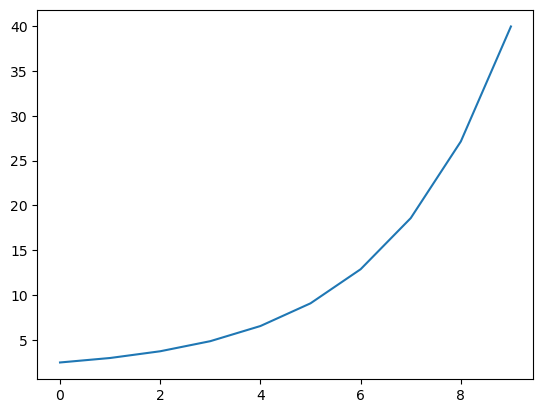

In [27]:
from matplotlib import pyplot as plt
import numpy as np

base = 1.5
fig = plt.figure()#figsize=(4, 2.67))
plt.plot(base + base**np.arange(10));

In [28]:
#| export

def exp_backoff(base:float=1.552, max_value:float=20.0):
    "Exponential backoff generator of values until cumulative value is max_value, then yields 0 and stops."
    if base <= 0: yield 0; return
    i, cum_sum, prev_t = 1, 0, 0
    while cum_sum < max_value:
        t = max(base**i, prev_t) if base > 1 else base*i
        t = min(t, max_value - cum_sum)
        yield t
        cum_sum += t
        prev_t = t
        i += 1
    yield 0

In [29]:
list(itertools.takewhile(lambda t: t, exp_backoff()))

[1.552, 2.408704, 3.7383086080000005, 5.8018549596160005, 6.499132432383998]

In [30]:
list(itertools.takewhile(lambda t: t, exp_backoff(max_value=60)))

[1.552,
 2.408704,
 3.7383086080000005,
 5.8018549596160005,
 9.004478897324033,
 13.9749512486469,
 21.68912433789999,
 1.8305779485130742]

In [31]:
list(itertools.takewhile(lambda t:t, exp_backoff(0.4, 3)))

[0.4, 0.8, 1.2000000000000002, 0.5999999999999996]

In [32]:
list(itertools.takewhile(lambda t:t, exp_backoff(1*0.0776, 1)))

[0.0776, 0.1552, 0.2328, 0.3104, 0.22399999999999998]

In [33]:
boff = iter(exp_backoff())
t, sum = 1, 0
while t:
    t = next(boff)
    sum += t
    print(t, sum)

1.552 1.552
2.408704 3.9607040000000002
3.7383086080000005 7.699012608
5.8018549596160005 13.500867567616002
6.499132432383998 20.0
0 20.0


In [34]:
#| exporti

_xx = ['-_-', 'o_o']
def _show(finish: bool=False):
    if finish: print('._.')
    else: print(_xx[0], end="\r", flush=True); _xx[:] = _xx[::-1]

In [35]:
class BlockingMixin(W.Widget):
    "A mixin for widgets that supports blocking custom messages with the front-end."
    _cbs: CallbackDispatcher

    def on_msg(self, cb, remove=False):
        if not hasattr(self, '_cbs'): self._cbs = CallbackDispatcher()
        self._cbs.register_callback(cb, remove=remove)
        super().on_msg(cb, remove=remove)

    def send(self, msg, timeout: float|None=None, buffers=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]|None:
        "Send `msg` to the front-end. If `timeout` seconds is not None, calling blocks."
        if timeout is None: 
            for cb in self._cbs.callbacks: super().on_msg(cb)
            return super().send(msg, buffers)
        for cb in self._cbs.callbacks: super().on_msg(cb, remove=True)
        res = self._send_msg(msg, buffers,timeout, sleep, n, show)
        # NOTE: restoring normal callbacks now implies that front-end can yet send back a result
        # even if python timeout was triggered.
        for cb in self._cbs.callbacks: super().on_msg(cb)
        return res
    
    async def asend(self, msg, timeout: float=5.0, buffers=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]|None:
        "Send `msg` to the front-end. Call will end after `timeout` seconds if `timeout` is not None."
        for cb in self._cbs.callbacks: super().on_msg(cb, remove=True)
        res = await self._asend_msg(msg, buffers, timeout, sleep, n, show)
        for cb in self._cbs.callbacks: super().on_msg(cb)
        return res

    def _send_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send blocking `msg` to the front-end. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        boff = iter(exp_backoff(timeout*0.776, timeout))
        timeout, start_time = next(boff), time.time()
        result = None
        def _on_msg(_, msg, buffers):
            nonlocal result
            if result is None: result = (msg, buffers)
        super().on_msg(_on_msg)  # register transient callback
        try:
            super().send(msg, buffers)
            with ui_events() as ui_poll:
                while True:
                    if sleep: time.sleep(sleep)
                    ui_poll(n)
                    if (time.time() - start_time) > timeout:
                        timeout, start_time = next(boff), time.time()
                        if not timeout: result = (empty, empty)
                    if result is not None:
                        content, buffers = result
                        if content is empty: return (empty, empty)
                        self._cbs(self, content, buffers)
                        return content, buffers
                    if show: show(False)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)  # unregister callback
            if show: show(True)

    async def _asend_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 0, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send async `msg` to the front-end. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        boff = iter(exp_backoff(timeout*0.776, timeout))
        timeout, start_time = next(boff), time.time()
        result = None
        def _on_msg(w, msg, buffers):
            nonlocal result
            if result is None: result = (msg, buffers)
        super().on_msg(_on_msg)
        try:
            super().send(msg, buffers)
            async with ui_events() as ui_poll:
                while True:
                    await ui_poll(10)
                    if (time.time() - start_time) > timeout:
                        timeout, start_time = next(boff), time.time()
                        if not timeout: result = (empty, empty)
                    if result is not None:
                        content, buffers = result
                        if content is empty: return (empty, empty)
                        self._cbs(self, content, buffers)
                        return (content, buffers)
                    if sleep: await asyncio.sleep(sleep)
                    if show: show(False)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)
            if show: show(True)

In [36]:
#| export

class BlockingMixin(W.Widget):
    "Mixin for widgets that supports blocking custom messages with the front-end."
    _loading = True

    @classmethod
    async def create(cls, 
        *args, 
        sleep:float=0.2, timeout:float=4.0,
        factory:Callable[..., Any]|None=None, on_end:Callable[[Any, bool], None]|None=None,
        **kwargs
    ) -> Self:
        start_time = time.time()
        self: Self = (factory or cls)(*args, **kwargs)
        if self._loading:
            async with ui_events() as ui_poll:
                while True:
                    await ui_poll(10)
                    if (time.time() - start_time) > timeout:
                        if on_end: on_end(self, False)
                        break
                    if not self._loading:
                        if on_end: on_end(self, True)
                        break
                    if sleep: await asyncio.sleep(sleep)
        return self

    def send(self, msg, timeout: float|None=None, buffers=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]|None:
        """Send `msg` to the front-end. If `timeout` seconds is not None, the calling blocks.
        NOTE: front-end can yet send back a result even if python timeout was triggered.
        """
        if timeout is None: return super().send(msg, buffers)
        return self._send_msg(msg, buffers, timeout, sleep, n, show)
    
    async def asend(self, msg, timeout: float=5.0, buffers=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]|None:
        """Send `msg` to the front-end. Call will end after `timeout` seconds if `timeout` is not None.
        NOTE: front-end can yet send back a result even if python timeout was triggered.
        """
        return await self._asend_msg(msg, buffers, timeout, sleep, n, show)

    def _send_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send blocking `msg` to the front-end. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        boff = iter(exp_backoff(timeout*0.776, timeout))
        timeout, start_time = next(boff), time.time()
        result = None
        def _on_msg(w, msg, buffers):
            nonlocal result
            if result is None: result = (msg, buffers)
        super().on_msg(_on_msg)
        try:
            super().send(msg, buffers)
            with ui_events() as ui_poll:
                while True:
                    if sleep: time.sleep(sleep)
                    ui_poll(n)
                    if (time.time() - start_time) > timeout:
                        timeout, start_time = next(boff), time.time()
                        if not timeout: result = (empty, empty)
                    if result is not None:
                        content, buffers = result
                        if content is empty: return (empty, empty)
                        return content, buffers
                    if show: show(False)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)
            if show: show(True)

    async def _asend_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 0, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send async `msg` to the front-end. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        boff = iter(exp_backoff(timeout*0.776, timeout))
        timeout = next(boff)
        start_time, result = time.time(), None
        def _on_msg(w, msg, buffers):
            nonlocal result
            if result is None: result = (msg, buffers)
        super().on_msg(_on_msg)
        try:
            super().send(msg, buffers)
            async with ui_events() as ui_poll:
                while True:
                    await ui_poll(10)
                    if (time.time() - start_time) > timeout:
                        timeout = next(boff)
                        if not timeout: result = (empty, empty)
                    if result is not None:
                        content, buffers = result
                        if content is empty: return (empty, empty)
                        return (content, buffers)
                    if sleep: await asyncio.sleep(sleep)
                    if show: show(False)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)
            if show: _show(True)

In [37]:
class BlockingWidget(anywidget.AnyWidget, BlockingMixin):
    _esm = anysource('debugger;', '''
    export default { 
        async initialize({ model }) {
            function on_msg(msg) {
                console.log(`Received message:`, msg);
                if (!msg?.timeout) return model.send({ id: msg.id, response: 'no timeout' });
                setTimeout(() => {
                    console.log(`Sending response for id:`, msg.id);
                    model.send({ id: msg.id, response: 'done waiting', error: null });
                }, msg.timeout*1000);
            }
            model.on("msg:custom", on_msg);
            setTimeout(() => {
                console.log(`Initialized.`);
                model.send({ response: 'Intialized' });
            }, 1000);
        }
    };
    ''')

    dh: DisplayHandle
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_update = None
        self.on_msg(self._handle_message)
        self.dh = displaydh('Initializing...')

    def _handle_message(self, w, msg, buffers):
        self._loading = False
        self.last_update = f'{time.time()} Received message: {msg}, buffers: {buffers}'
        self.dh.update(self.last_update)

In [38]:
cleanupwidgets('w')

w = await BlockingWidget.create(on_end=lambda w,x: w.dh.update(f'done={x}'))
test_eq(w._loading, False)
w.last_update

'done=True'

"1742118907.1049879 Received message: {'response': 'Intialized'}, buffers: []"

In [39]:
cleanupwidgets('w')

w = BlockingWidget()
test_eq(w._loading, True)

"1742118911.1696022 Received message: {'id': 5, 'response': 'done waiting', 'error': None}, buffers: []"

In [40]:
w.dh.update('...')
w.send({'id': kounter('blocking')})

In [41]:
w.dh.update('...')
a = w.send({'id': kounter('blocking'), 'timeout': 2}, 3, show=_show)
print(f"{a=}")

._.
a=({'id': 1, 'response': 'no timeout'}, [])


In [42]:
w.dh.update('...')
a = w.send({'id': (cnt := kounter('blocking')), 'timeout': 2}, 1, show=_show)
print(f"{cnt}, {a=}")

._.
3, a=({'response': 'Intialized'}, [])


In [43]:
w.dh.update('...')
a = await w.asend({'id': kounter('blocking'), 'timeout': 2}, 3, show=_show)
print(f"{a=}")

._.
a=({'id': 2, 'response': 'done waiting', 'error': None}, [])


In [44]:
w.dh.update('...')
a = await w.asend({'id': kounter('blocking'), 'timeout': 2}, 1, show=_show)
print(f"{a=}")

._.
a=({'id': 3, 'response': 'done waiting', 'error': None}, [])


# Colophon
----

In [50]:
import fastcore.all as FC
import nbdev
from nbdev.clean import nbdev_clean

In [51]:
if FC.IN_NOTEBOOK:
    nb_path = '02_widget_helpers.ipynb'
    # nbdev_clean(nb_path)
    nbdev.nbdev_export(nb_path)